In [2]:
import warnings
warnings.filterwarnings('ignore')

ROOT_DATASETS = '/media/arthur/DATA/Data sets/MTH7017P/'

from utils import *

set_cache_dir('pickles/slides9')

RUN_DOWNLOADS = False

# Creating Synthetic Natural Disaster Data

This week we investigate some approaches for generating synthetic natural disaster data.

<div class="alert alert-block alert-info">
<b>Our objectives:</b> 
<p>
<ul>
<li>Understand data-based versus physics-based approaches for synthesis</li>
<li>Carry out basic time series modelling</li>
<li>Write a simple data-based synthesizer</li>
</ul>
</p>
</div>

## Data-based versus Physics-Based approaches

We previously saw that we can incorporate Monte-Carlo / synthetic natural disaster data into our Climate Risk Analysis. However we did not dive into how these synthetic data are generated. We can categorize approaches into two mechanisms:

1. Data-based approaches
2. Physics-based approaches

Data-based approaches solely rely on data, whether it be reanalysis data (past and present climate) or climate projections from climate models. 

Physics-based approaches leverage physics models.

As a very basic example, consider the non-weather scenario of someone dropping a ball from a high tower. Due to wind, there will be uncertainty about the location of the impact of the ball with the ground. We assume we have thrown the ball many times and collected measurements about impact locations and the wind.

1. A data-based approach would consist in directly modelling the distribution of the impact. We could then sample synthetic locations from that distribution.
2. A physics-based approach would consist, for instance, into writing the equations of motions and integrating them to simulate the ball's trajectory.

| Method | Pros | Cons |
|:-------------|:-------------|:--------------|
| Data-based   | Low bias      | Difficult to account for Climate Change         |
| Physics-based| Can incorporate Climate change        | Physics model might introduce bias   |



## Example: a data-based approach for the synthesis of Tropical Cyclones

We discuss the method proposed in the following manuscript:

[Yonekura E, Hall TM (2011) A statistical model of tropical cyclone tracks in the Western North Pacific with
ENSO-dependent cyclogenesis. J Appl Meteorol Clim 50:1725–1739](https://journals.ametsoc.org/view/journals/apme/50/8/2011jamc2617.1.pdf). 

The goal of this method is to synthesize realistic Tropical Cyclones falling on land in the Western North Pacific.

![tcs](tcs_paper.png)

### Data

The method leverages historic data from IBTrACS (The International Best Track Archive for Climate Stewardshi, the same resource we accessed in CLIMADA). In particular, the method aims at simulating TC trajectories from their genesis in the oceans to their lysis (death). This is in contrast to other data-based approaches that only model intensities of TCs that impact land.

### Methods

The method relies on 3 components:

1. Genesis: number of cyclones forming annually, and where they form
2. Propagation: trajectory of the cyclone
3. Lysis: death of the cyclone

This is a rather common framework. For instance, we could take a similar approach to synthesize wildfire events (see e.g. [Ioannis Zacharakis, Vassilios A. Tsihrintzis,
Integrated wildfire danger models and factors: A review,
Science of The Total Environment,
Volume 899,
2023](https://www.sciencedirect.com/science/article/pii/S0048969723043279?via%3Dihub)).

We now discuss those three components in more details.

### Genesis component

The genesis component is concerned with:
1. Modelling the annual number of TCs forming in the Western Noth Pacific (WNP)
2. Modelling the locations where those TCs form

To model the annual number of TCs that form in the WNP, the authors use a Poisson distribution (standard for count data). This can be achieved by collecting from the data the annual number of TCs that occur, say $x_1, \ldots, x_n$ if we have a record of $n$ years, and estimating the parameter $\mu$ of the Poisson distribution via maximum likelihood estimation. This model can be written as,
\begin{equation}
    X\sim Poisson(\mu),
\end{equation}
the random variable $X$ denoting the number of annual TCs.

In practice, the approach they follow is slightly more subtle: they incorporate some dependence on a climatological factor, the ENSO index for the year via regression. This can be written as,

\begin{equation}
    X_i \sim Poisson(\mu_i), \quad i=1,\ldots, n,
\end{equation}
where $i$ indexes the year, and,
\begin{equation}
    \mu_i = \exp(\beta_0 + \beta_1 ENSO_i).
\end{equation}

$ENSO_i$ is the ENSO index for the year with index $i$.
This time, the parameters of this model are $\beta_0, \beta_1$. Again, they can be estimated via maximum-likelihood.

To model the locations of formation of the TCS, we estimate the probability density function of the locations. For instance, we can achieve this using a Kernel Density Estimator.

<div class="alert alert-block alert-info">
<b>Definition: Kernel Density Estimator</b> 
<p>
    Let $X_1, \ldots, X_n$ be an i.i.d. sample from a random variable $X$ with unknown probability density function $f$. A Kernel Density Estimator of $f$ is defined by:
    \begin{equation}
        \widehat{f}_n(x) = \frac{1}{n}\sum_{i=1}^{n}{K(x - x_i; \sigma)},
    \end{equation}
    where $K(x; \sigma)$ is a Kernel, i.e. it satisfies,
    <ul>
        <li>$\int K(x)dx = 1$ (so that $\int \widehat{f}_n(x) dx = 1$)</li>
        <li>$\int xK(x)dx = 0$</li>
        <li>$\int x^2 K(x)dx = \sigma^2$</li>
    </ul>
</p>
</div>

Here the kernel parameter $\sigma$ will determine the *smoothness* of the estimated density.

In the paper, they follow a slightly more subtle approach where they again use a regression in terms of the ENSO index. 

![image](betas1.png)

### Propagation component

The propagation component of the model aims at representing the trajectory of a Tropical Cyclone.
We need a few mathematical tools from time series modelling (Slides in section Week 9).

For simplicity, here we write the propagation model in 1d. However, the full model is 2d, corresponding to both latitude and longitude.

Let $Z_t$ be the location at time $t$. The model can be written as,

\begin{equation}
    Z_{t + 1} = Z_t + \epsilon_t,
\end{equation}

where $\epsilon_t = \mu(Z_t) + \sigma(Z_t) \cdot \widetilde{\epsilon}_t$ and $\widetilde{\epsilon}_t$ is an AR(1) process. 

1. $\mu(\cdot)$ is a spatially-dependent mean increment.
2. $\sigma(\cdot)$ is a spatially-dependent standard deviation of the increments.

Questions:
1. What happens if $\sigma(\cdot)$ is always zero in our model?
2. What happens if $\mu(\cdot)$ is always zero in our model?
3. What happens if both functions are always zero in our model?
4. What happens if $\mu(\cdot)$ is always non-negative?

In [20]:
import matplotlib.pyplot as plt
from ar1 import AR1
import numpy as np

ar = AR1(0.8, sigma=0.2)
epsilons_tilde = ar.sample(1000)

Zs = np.cumsum(delta + 2 + epsilons_tilde)

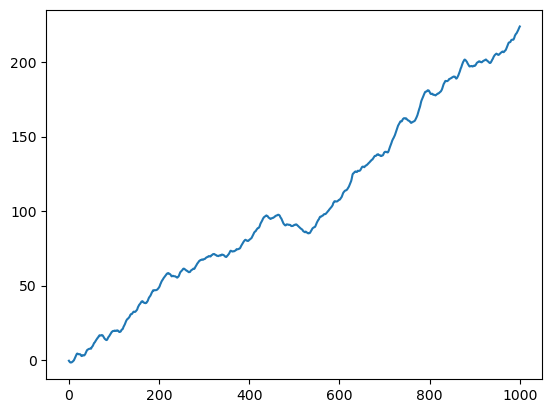

In [21]:
plt.figure()
plt.plot(Zs)

### Lysis component

The model for lysis is a simple Bernoulli random variable whose parameter is estimated by taking the ratio of end points by the total number of track points. 

### Intensity

The discussed manuscript does not directly address the modelling of wind intensity. However, a standard data-based approach might rely on an autoregressive process.

## Example: a Physics-based model for the synthesis of Tropical Cyclones

We now discuss a Physics-based model, presented in the following manuscript:

[Emanuel, K., R. Sundararajan, and J. Williams, 2008: Hurricanes and Global Warming: Results from Downscaling IPCC AR4 Simulations. Bull. Amer. Meteor. Soc., 89, 347–368](https://doi.org/10.1175/BAMS-89-3-347)

This event generator is entirely free from historical storm data. Instead, it randomly seeds *mini-cyclones* and uses reanalysis data / climate model data that are fed into a simple physics model of Tropical Cyclone trajectory and intensity. 

> Because such a method is based purely on physics applied to large-scale environmental conditions, it can be driven by climate model output as well as by global reanalysis data, allozing for quantification of the effect of climate variability and trends on tropical cyclone genesis, tracks, and intensity.
>
> — Emmanuel, K., 2017. *A fast intensity simulator for tropical cyclone risk analysis. Nat Hazards, 88:779–796*